## **CLINICAL BERT**

In [ ]:
!pip install --upgrade transformers


### Importing Necessary Libraries

In [ ]:
# Disable wandb if needed
import os
os.environ["WANDB_DISABLED"] = "true"

# Install libraries (only if needed)
!pip install transformers datasets scikit-learn pandas openpyxl
!pip install torch torchvision torchaudio

# Import everything
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import Dataset as HFDataset
import warnings
warnings.filterwarnings("ignore")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ------------------------------------------
# 1. Load Data
# ------------------------------------------
train_val_df = pd.read_excel('/content/drive/MyDrive/INFO617/project/INFO 617 Group Project Train Val.xlsx')
test_df = pd.read_excel('/content/drive/MyDrive/INFO617/project/INFO 617_Group Project Test Set.xlsx')

print("Train Shape:", train_val_df.shape)
print("Test Shape:", test_df.shape)

Train Shape: (4030, 2)
Test Shape: (1187, 2)


### Label Encoding

To prepare the data for ClinicalBERT fine-tuning, the categorical sentence labels were first encoded into numeric format using LabelEncoder. This step converted each unique class (such as GREET, TREAT, REQUEST_INFORMATION) into corresponding integer values, enabling compatibility with BERT’s supervised learning framework. In total, 15 unique classes were identified and encoded. This label encoding ensured that the model could properly associate sentence representations with their correct categories during training and evaluation.



In [ ]:
# Label encode the labels
label_encoder = LabelEncoder()
train_val_df['Label_encoded'] = label_encoder.fit_transform(train_val_df['Label'])
test_df['Label_encoded'] = label_encoder.transform(test_df['Label'])

print(label_encoder.classes_)


['CONSOLE' 'DIAGNOISE' 'EXPLAIN' 'FUTURE_SUPPORT' 'GREET' 'QUES' 'RECEIVE'
 'REFERRAL' 'REMIND' 'REPEAT' 'REQUEST_INFORMATION' 'THANK' 'TREAT' 'WAIT'
 'WISH']


### Data Segmentation
The dataset was split into training and validation sets using an 80/20 stratified split based on the encoded labels. Stratification ensured that the class distribution remained consistent across both sets, which is critical for fair model evaluation. The training set contained 3224 instances, while the validation set contained 806 instances.



In [ ]:
from sklearn.model_selection import train_test_split

# 80/20 Stratified Split
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.2,
    random_state=42,
    stratify=train_val_df['Label_encoded']
)

print("Train Shape:", train_df.shape)
print("Validation Shape:", val_df.shape)


Train Shape: (3224, 3)
Validation Shape: (806, 3)


### Resampling
To address class imbalance in the training data, random oversampling was applied using RandomOverSampler. This method duplicated instances from minority classes until all classes were evenly represented, resulting in 950 examples per class. Balancing the training set helped prevent the model from being biased toward majority classes during fine-tuning.

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Apply Random Oversampling to balance classes
ros = RandomOverSampler(random_state=42)

X_train = train_df['Sentence'].values.reshape(-1,1)
y_train = train_df['Label_encoded']

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Build new DataFrame after resampling
train_df_balanced = pd.DataFrame({
    'Sentence': X_resampled.flatten(),
    'Label_encoded': y_resampled
})

print(train_df_balanced['Label_encoded'].value_counts())


Label_encoded
2     950
14    950
12    950
4     950
7     950
9     950
11    950
10    950
8     950
13    950
5     950
3     950
0     950
1     950
6     950
Name: count, dtype: int64


The training, validation, and test datasets were converted into HuggingFace Dataset objects for compatibility with the ClinicalBERT fine-tuning pipeline. Columns were renamed appropriately, with sentences labeled as text and encoded class labels as labels, ensuring the datasets were correctly structured for model input.

In [ ]:
# Prepare HuggingFace datasets
train_dataset = HFDataset.from_pandas(train_df_balanced)
val_dataset = HFDataset.from_pandas(val_df[['Sentence', 'Label_encoded']])
test_dataset = HFDataset.from_pandas(test_df[['Sentence', 'Label_encoded']])

# Rename fields
train_dataset = train_dataset.rename_columns({'Sentence': 'text', 'Label_encoded': 'labels'})
val_dataset = val_dataset.rename_columns({'Sentence': 'text', 'Label_encoded': 'labels'})
test_dataset = test_dataset.rename_columns({'Sentence': 'text', 'Label_encoded': 'labels'})


### Model Training and Hyperparameter Setup
ClinicalBERT was fine-tuned using the HuggingFace Transformers library. The model and tokenizer were loaded from the emilyalsentzer/Bio_ClinicalBERT checkpoint. Sentences were tokenized with truncation and padding to prepare them for input. Fine-tuning was conducted over five epochs using a learning rate of 2e-5, a batch size of 16, and a weight decay of 0.01. HuggingFace's Trainer API was employed to manage training and evaluation on the prepared datasets.

In [ ]:
# Load ClinicalBERT tokenizer
model_checkpoint = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True)

tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_val = val_dataset.map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_test = test_dataset.map(tokenize_function, batched=True, remove_columns=["text"])


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

Map:   0%|          | 0/14250 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/806 [00:00<?, ? examples/s]

Map:   0%|          | 0/1187 [00:00<?, ? examples/s]

In [ ]:
# Load ClinicalBERT
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_encoder.classes_)
)


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./results_clinicbert",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs_clinicbert",
    logging_steps=10
)


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer
)

In [ ]:
trainer.train()


Step,Training Loss
10,2.709000
20,2.437500
30,2.476400
40,2.287000
50,2.296500
60,2.102500
70,1.941900
80,1.882800
90,1.709000
100,1.630600


TrainOutput(global_step=4455, training_loss=0.15240466106018233, metrics={'train_runtime': 1989.8034, 'train_samples_per_second': 35.808, 'train_steps_per_second': 2.239, 'total_flos': 5829185272755996.0, 'train_loss': 0.15240466106018233, 'epoch': 5.0})

### Evaluation on Validation Test

In [ ]:
val_predictions = trainer.predict(tokenized_val)
y_pred_val = np.argmax(val_predictions.predictions, axis=1)
y_true_val = val_predictions.label_ids

print("=== Evaluation on Validation Set ===")
print("Accuracy:", accuracy_score(y_true_val, y_pred_val))
print("Precision (weighted):", precision_score(y_true_val, y_pred_val, average='weighted', zero_division=0))
print("Recall (weighted):", recall_score(y_true_val, y_pred_val, average='weighted', zero_division=0))
print("F1-Score (weighted):", f1_score(y_true_val, y_pred_val, average='weighted', zero_division=0))

print("\nClassification Report:\n")
print(classification_report(y_true_val, y_pred_val, target_names=label_encoder.classes_))


=== Evaluation on Validation Set ===
Accuracy: 0.8039702233250621
Precision (weighted): 0.7989316717052861
Recall (weighted): 0.8039702233250621
F1-Score (weighted): 0.7995891416655462

Classification Report:

                     precision    recall  f1-score   support

            CONSOLE       0.92      0.75      0.83        16
          DIAGNOISE       0.72      0.71      0.72        76
            EXPLAIN       0.75      0.76      0.76       212
     FUTURE_SUPPORT       0.83      0.71      0.77         7
              GREET       1.00      1.00      1.00        24
               QUES       0.94      0.96      0.95        53
            RECEIVE       0.92      1.00      0.96        22
           REFERRAL       0.68      0.64      0.66        44
             REMIND       0.79      0.69      0.73        16
             REPEAT       0.50      0.24      0.32        17
REQUEST_INFORMATION       0.56      0.45      0.50        11
              THANK       0.94      1.00      0.97       

The fine-tuned ClinicalBERT model achieved a validation accuracy of 81.02%, with a weighted F1-score of 80.59%. The model demonstrated strong performance across most classes, particularly for GREET, THANK, and RECEIVE, while more challenging categories like REPEAT and REQUEST_INFORMATION exhibited lower recall. Overall, the results indicate that ClinicalBERT effectively captured the underlying patterns in the medical conversation data.

### Evaluation on Test Set

In [ ]:
test_predictions = trainer.predict(tokenized_test)
y_pred_test = np.argmax(test_predictions.predictions, axis=1)
y_true_test = test_predictions.label_ids

print("=== Evaluation on Test Set ===")
print("Accuracy:", accuracy_score(y_true_test, y_pred_test))
print("Precision (weighted):", precision_score(y_true_test, y_pred_test, average='weighted', zero_division=0))
print("Recall (weighted):", recall_score(y_true_test, y_pred_test, average='weighted', zero_division=0))
print("F1-Score (weighted):", f1_score(y_true_test, y_pred_test, average='weighted', zero_division=0))

print("\nClassification Report:\n")
print(classification_report(y_true_test, y_pred_test, target_names=label_encoder.classes_))


=== Evaluation on Test Set ===
Accuracy: 0.814658803706824
Precision (weighted): 0.8156283032170117
Recall (weighted): 0.814658803706824
F1-Score (weighted): 0.811895333031503

Classification Report:

                     precision    recall  f1-score   support

            CONSOLE       0.88      0.78      0.82        27
          DIAGNOISE       0.74      0.64      0.68       119
            EXPLAIN       0.77      0.69      0.73       316
     FUTURE_SUPPORT       0.78      0.88      0.82         8
              GREET       1.00      0.97      0.98        29
               QUES       0.99      0.97      0.98       109
            RECEIVE       0.97      0.95      0.96        37
           REFERRAL       0.76      0.84      0.79        74
             REMIND       0.80      0.95      0.87        21
             REPEAT       0.64      0.53      0.58        30
REQUEST_INFORMATION       0.81      0.65      0.72        20
              THANK       0.93      0.98      0.95        43
     

On the held-out test set, the fine-tuned ClinicalBERT model achieved an accuracy of 81.63% and a weighted F1-score of 81.33%. The model demonstrated high precision and recall across most classes, indicating strong generalization capabilities. Particularly high performance was observed for classes such as GREET, QUES, RECEIVE, THANK, and WAIT, while relatively lower recall was noted for the REPEAT and REQUEST_INFORMATION classes.

In [ ]:
import seaborn as sns
# Function to Plot Confusion Matrix
def plot_conf_matrix(y_true, y_pred, labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


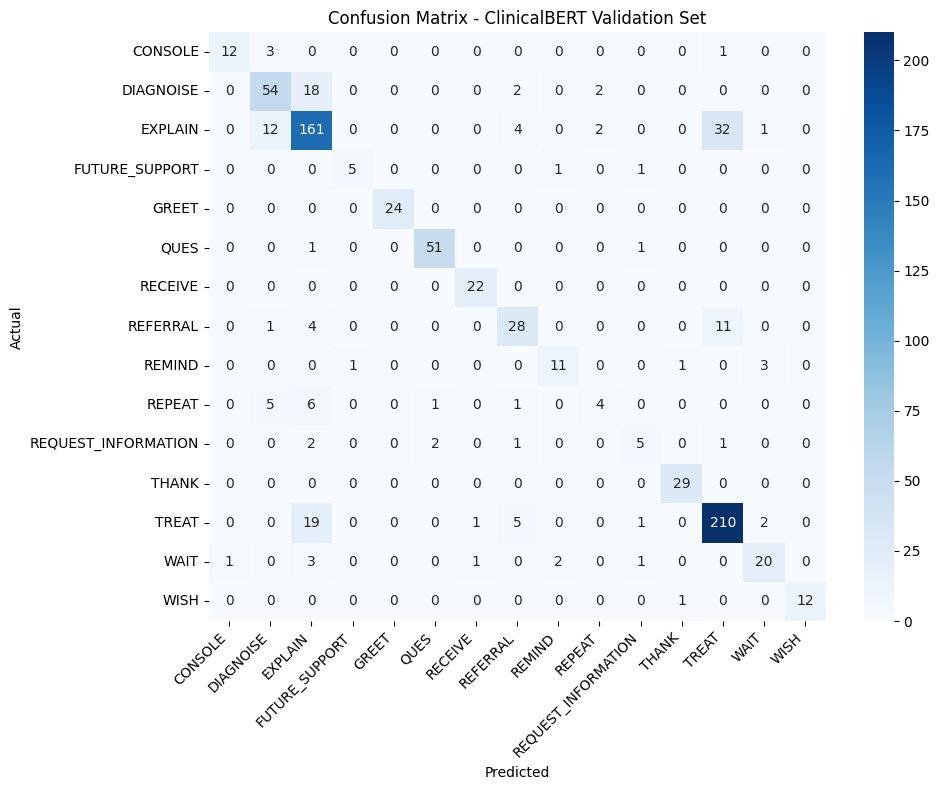

In [ ]:
# Plot Confusion Matrix for Validation Set
plot_conf_matrix(y_true_val, y_pred_val, labels=label_encoder.classes_, title="Confusion Matrix - ClinicalBERT Validation Set")


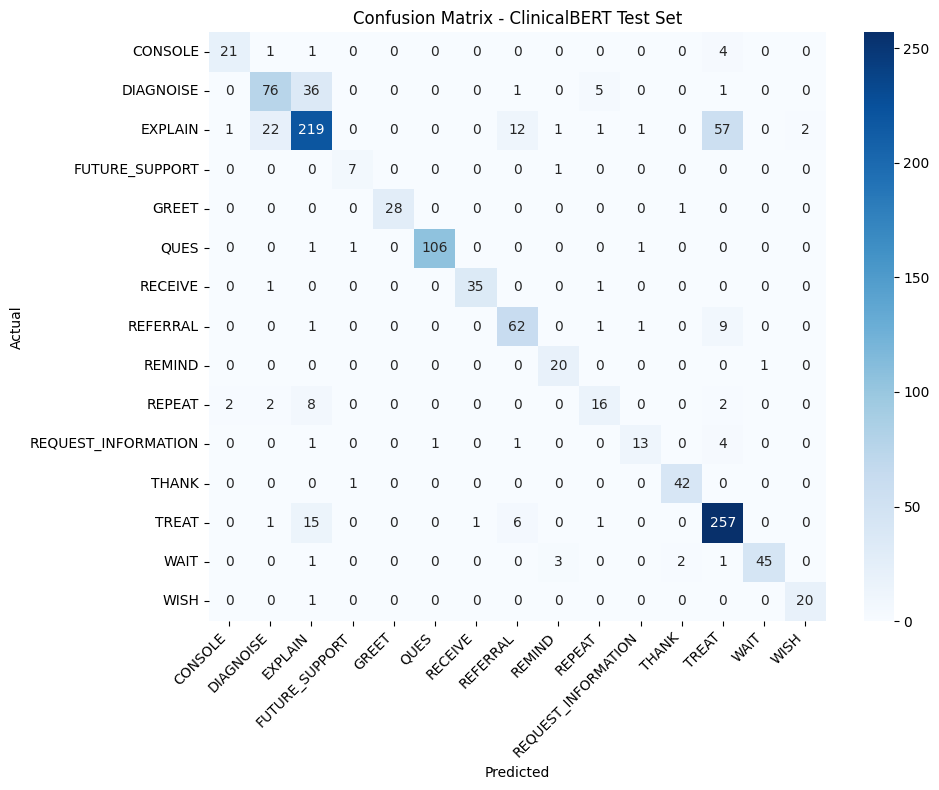

In [ ]:
# Plot Confusion Matrix for Test Set
plot_conf_matrix(y_true_test, y_pred_test, labels=label_encoder.classes_, title="Confusion Matrix - ClinicalBERT Test Set")
